In [1]:
import torch
import numpy as np
from scipy.io import loadmat, savemat
from scipy import constants as cts
from tqdm import tqdm
from ipywidgets import interact, widgets
import matplotlib.pyplot as plt
%matplotlib inline


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

disp = loadmat('disp.mat')
res = loadmat('res.mat')
sim = loadmat('sim.mat')

sim['DKS_init'] = np.array([complex(x.strip()) for x in sim['DKS_init']])

# Convert the complex numbers to np.complex64
sim['DKS_init'] = sim['DKS_init'].astype(np.complex128)

tol = 1e-3
max_iter = 10
step_factor = 0.1

c0 = 299792458
h_bar = cts.hbar

In [2]:
# write a function that converts the dictorionary to a tensor. Drop the first 3 keys
def dict_to_tensor(dic):
    dic.pop('__header__', None)
    dic.pop('__version__', None)
    dic.pop('__globals__', None)
    dic.pop('dispfile', None)

    tensor_dic = dict()
    # convert the dictionary to a tensor
    for key in dic:
        if isinstance(dic[key], np.ndarray):
            if key == 'DKS_init':
                tensor_dic[key] = torch.tensor(dic[key], device=device, dtype=torch.complex64)
            else:
                dic[key] = np.where(dic[key] == 'None', None, dic[key])
                dic[key] = dic[key].astype(np.float64)
                tensor_dic[key] = torch.tensor(dic[key], device=device)
        else:
            tensor_dic[key] = dic[key]
    return tensor_dic

def tensor_to_dict(tensor):
    dic = dict()
    for key in tensor:
        # print(key)
        if isinstance(tensor[key], torch.Tensor):
            if tensor[key].dtype == torch.complex128:
                dic[key] = tensor[key].cpu().numpy().astype(np.complex128)
            else:   
                dic[key] = tensor[key].cpu().numpy().astype(np.float64)
        else:
            dic[key] = tensor[key]
    return dic

disp_tensor = dict_to_tensor(disp)
res_tensor = dict_to_tensor(res)
sim.pop('domega', None)
sim['domega'] = np.array(['None',0])
sim_tensor = dict_to_tensor(sim)

In [3]:
disp_tensor['D1'] = disp_tensor['D1'][0]
disp_tensor['FSR'] = disp_tensor['FSR'][0]
disp_tensor['FSR_center'] = disp_tensor['FSR_center'][0]

for key in res_tensor:
    res_tensor[key] = res_tensor[key][0]

# if ndim>1 then squeeze the tensor
for key in sim_tensor:
    if sim_tensor[key].ndim > 1:
        sim_tensor[key] = sim_tensor[key][0]


In [4]:
ng = disp_tensor['ng']
R = res_tensor['R']
gamma = res_tensor['gamma']
L = 2*torch.pi*R
# print all shapes
# print('ng:', ng.shape)
# print('R:', R.shape)
# print('gamma:', gamma.shape)
# %%
Q0 = res_tensor['Qi']
Qc = res_tensor['Qc']
fpmp = sim_tensor['f_pmp']
Ppmp = sim_tensor['Pin']
phi_pmp = sim_tensor['phi_pmp']
num_probe = sim_tensor['num_probe']
num_probe = num_probe[0].cpu().numpy().astype(int)
fcenter = sim_tensor['f_center']

DKSinit_real = torch.real(sim_tensor['DKS_init'])
if sim_tensor['DKS_init'].dtype == 'complex128':
    DKSinit_imag = torch.imag(sim_tensor['DKS_init'])
else:
    DKSinit_imag = torch.zeros_like(DKSinit_real, device=device)

In [5]:
DKS_init = torch.complex(DKSinit_real, DKSinit_imag)

D1 = disp_tensor['D1']
FSR = D1/(2*torch.pi)
omega0 = 2*torch.pi*fpmp
omega_center = 2*torch.pi*fcenter

tR = 1/FSR
T = 1*tR
kext = (omega0[0]/Qc) * tR
k0 = (omega0[0]/Q0) * tR
alpha = k0+kext

del_omega_init = sim_tensor['domega_init']
del_omega_end = sim_tensor['domega_end']
del_omega_stop = sim_tensor['domega_stop']
ind_sweep = sim_tensor['ind_pump_sweep'] 
t_end = sim_tensor['Tscan']
Dint = disp_tensor['Dint_new']#[0]

In [6]:
del_omega = sim['domega']
ind_pmp = [ii for ii in sim_tensor['ind_pmp'].int().cpu().numpy()]    
mu_sim = sim_tensor['mucenter']
mu = torch.arange(mu_sim[0], mu_sim[1]+1, device=device)
# find center of mu
mu0 = torch.where(mu == 0)[0][0].int().cpu().numpy()+1

d_omega = 2*torch.pi*FSR * torch.arange(mu_sim[0], mu_sim[-1]+1, device=device)
domega_pmp1 = 2*torch.pi*FSR * torch.arange(mu_sim[0]-ind_pmp[0]-1, mu_sim[-1]-ind_pmp[0], device=device)
omega1 = omega0[0] + domega_pmp1

Dint = Dint-Dint[mu0]

Ptot = torch.zeros(1, device=device)
for ii in range(len(fpmp)):
    Ptot += Ppmp[ii]

dt = 1
t_end = t_end*tR
t_ramp = t_end

In [7]:
Nt = torch.round(t_ramp/tR/dt)[0].int()
theta = torch.linspace(0, 2*torch.pi, len(mu), device=device)
del_omega_tot = torch.abs(del_omega_end)+torch.abs(del_omega_init)
del_omega_perc = -1*torch.sign(del_omega_end+del_omega_init)*(torch.abs(del_omega_end+del_omega_init)/2)/del_omega_tot
t_sim = torch.linspace(-t_ramp[0]/2 + del_omega_perc[0]*t_ramp[0], t_ramp[0]/2 + del_omega_perc[0]*t_ramp[0], Nt, device=device, dtype=torch.float64)

# xx = torch.arange(0,Nt, device=device)
del_omega_all = torch.ones(len(fpmp), Nt, device=device, dtype=torch.float64)
# ind_sweep = ind_sweep.cpu().numpy().int()
xx = torch.arange(1,Nt+1, device=device)
for ii in ind_sweep.cpu().numpy().astype(int):
    # del_omega_all[ii,:] = torch.linspace(del_omega_init[0], del_omega_end[0], Nt)
    del_omega_all[ii,:] = del_omega_init + xx/Nt * (del_omega_end - del_omega_init)

In [8]:
def Noise():
    Ephoton = torch.tensor(h_bar)*omega1
    phase = 2*torch.pi*torch.rand(len(mu),1, device=device)
    array = torch.rand(len(mu),1, device=device)
    Enoise = array*torch.sqrt(Ephoton/2)*torch.exp(1j*phase)*len(mu)
    return torch.fft.ifftshift(torch.fft.ifft(Enoise))
# fpmp = fpmp[0]
Ain = torch.zeros(len(fpmp), len(mu),dtype=torch.complex128, device=device)
Ein = torch.zeros(len(fpmp), len(mu),dtype=torch.complex128, device=device)

for ii in range(len(fpmp)):
    Ein[ii,int(mu0+ind_pmp[ii])] = torch.sqrt(Ppmp[ii])*len(mu)
    Ain[ii] = torch.fft.ifft(torch.fft.fftshift(Ein[ii]))*torch.exp(1j*phi_pmp[ii])

# u0 = torch.zeros(len(mu) , dtype=torch.complex128, device=device)
u0 = DKS_init

In [9]:
saved_data = dict()

saved_data['u_probe'] = torch.zeros(num_probe, len(u0), dtype=torch.complex128, device=device)
saved_data['driving_force'] = torch.zeros(num_probe, len(u0), dtype=torch.complex128, device=device)
saved_data['detuning'] = torch.zeros(num_probe, device=device)
saved_data['t_sim'] = torch.zeros(num_probe, device=device)
saved_data['kappa_ext'] = kext
saved_data['kappa_0'] = k0
saved_data['alpha'] = alpha

# dint2 = loadmat('dint.mat')['dint'][:,0]
# Dint_shift = torch.Tensor(dint2, device=device, dtype=torch.complex128)
Dint_shift = torch.fft.ifftshift(Dint)
# %%
def Fdrive(it):
    Force = 0*torch.exp(1j*theta)
    for ii in range(len(fpmp)):
        if ii > 0:
            sigma = (2*del_omega_all[ii,it] + Dint[mu0+ind_pmp[ii]] - 0.5*del_omega_all[0,it])*t_sim[it]
        else:
            sigma=torch.zeros(1, device=device)
        Force = Force - 1j*Ain[ii]*torch.exp(1j*sigma)
    return Force #+ Noise()[0]

# def Fdrive_all():
#     Force = 0*torch.exp(1j*theta)
#     for ii in range(len(fpmp)):
#         if ii > 0:
#             sigma = (2*del_omega_all[ii,:] + Dint[mu0+ind_pmp[ii]] - 0.5*del_omega_all[0][:])*t_sim
#         else:
#             sigma=torch.zeros(1, device=device)
#         Force = Force - 1j*Ain[ii]*torch.exp(1j*sigma)
#     return Force #+ Noise()[0]

def SaveStatus_Callback(it, saved_data, u0, param):
    # if it*num_probe/Nt > param['probe']:
    saved_data['u_probe'][param['probe'],:] = u0
    saved_data['detuning'][param['probe']] = del_omega_all[0][it]
    saved_data['t_sim'][param['probe']] = t_sim[it]
    saved_data['driving_force'][param['probe'],:] = Fdrive(it)
    param['probe'] += 1
    return param

def SaveData(saved_data):
    saved_data_numpy = tensor_to_dict(saved_data)
    savemat('SSFM_half_data.mat', saved_data_numpy)

In [10]:
tol = 1e-3
max_iter = 10
success = False

L_h_prop = torch.zeros(len(mu), dtype=torch.complex128, device=device)
# L_h_prop_cpl = torch.zeros(len(mu), dtype=torch.complex128, device=device)
A_L_h_prop = torch.zeros(len(mu), dtype=torch.complex128, device=device)
NL_h_prop = torch.zeros(len(mu), dtype=torch.complex128, device=device)
# CPL_h_prop = torch.zeros(len(mu), dtype=torch.complex128, device=device)
A_h_prop = torch.zeros(len(mu), dtype=torch.complex128, device=device)
A_prop = torch.zeros(len(mu), dtype=torch.complex128, device=device)
NL_h_prop_1 = torch.zeros(len(mu), dtype=torch.complex128, device=device)
NL_prop = torch.zeros(len(mu), dtype=torch.complex128, device=device)
Force = torch.zeros(len(mu), dtype=torch.complex128, device=device)
# retL = torch.zeros(len(mu), dtype=torch.complex128, device=device)
# Eout = torch.zeros(len(mu), dtype=torch.complex128, device=device)
# Aout = torch.zeros(len(mu), dtype=torch.complex128, device=device)
# retNL = torch.zeros(len(mu), dtype=torch.complex128, device=device)
# retCPL = torch.zeros(len(mu), dtype=torch.complex128, device=device)

In [11]:
@torch.jit.script
def FFT_Lin(it: int, alpha: torch.Tensor, Dint_shift: torch.Tensor, del_omega_all: torch.Tensor, tR: torch.Tensor) -> torch.Tensor:
    '''
    Linear operator
    Input:
        it (int) : Time index
        alpha (torch.Tensor) : Linewidth enhancement factor
        Dint_shift (torch.Tensor) : Dispersive operator
        del_omega_all (torch.Tensor) : Detuning
        tR (torch.Tensor) : Round trip time
    Output:
        torch.Tensor : Linear operator
    '''
    return (-alpha / 2) + 1j * (Dint_shift - del_omega_all[0, it]) * tR


# Function for the Nonlinear operator
@torch.jit.script
def NL(uu: torch.Tensor, gamma: torch.Tensor, L: torch.Tensor) -> torch.Tensor:
    '''
    Nonlinear operator
    Input:
        uu (torch.Tensor) : Input field
        gamma (torch.Tensor) : Nonlinear coefficient
        L (torch.Tensor) : Length of the resonator
    Output:
        torch.Tensor : Nonlinear operator
    '''
    return -1j * (gamma * L * torch.square(torch.abs(uu)) )

In [ ]:
@torch.jit.script
def ssfm_step(A0: torch.Tensor, it: int, alpha: torch.Tensor, Dint_shift: torch.Tensor,
              del_omega_all: torch.Tensor, tR: torch.Tensor, gamma: torch.Tensor, L: torch.Tensor, 
              max_iter: int, tol: float, dt: int, kext: torch.Tensor, Fdrive_val:torch.Tensor, A_prop:torch.Tensor) -> torch.Tensor:
    
    A0 = A0 + Fdrive_val * torch.sqrt(kext) * dt
    L_h_prop = torch.exp(FFT_Lin(it, alpha, Dint_shift, del_omega_all, tR) * dt / 2)
    A_L_h_prop = torch.fft.ifft(torch.fft.fft(A0) * L_h_prop)
    NL_h_prop_0 = NL(A0, gamma, L)
    A_h_prop = A0#.clone()
    # A_prop = torch.zeros_like(A0, dtype=torch.complex128, device=A0.device)

    for _ in range(max_iter):
        err=0
        NL_h_prop_1 = NL(A_h_prop, gamma, L)
        NL_prop = (NL_h_prop_0 + NL_h_prop_1) * dt / 2
        A_prop = torch.fft.ifft(torch.fft.fft(A_L_h_prop * torch.exp(NL_prop)) * L_h_prop)
        err = torch.linalg.vector_norm(A_prop - A_h_prop, ord=2, dim=0) / torch.linalg.vector_norm(A_h_prop, ord=2, dim=0)
        if err < tol:
            return A_prop
        A_h_prop = A_prop
    err = torch.linalg.vector_norm(A_prop - A_h_prop, ord=2, dim=0) / torch.linalg.vector_norm(A_h_prop, ord=2, dim=0)
    raise RuntimeError(f"Convergence Error: {err}")

def MainSolver(Nt, saved_data, u0):
    param = dict()
    param['tol'] = 1e-3
    param['max_iter'] = max_iter
    param['step_factor'] = 0.1
    param['probe'] = 0

    for it in tqdm(range(Nt), ncols=120):
        Fdrive_val = Fdrive(it)
        u0 = ssfm_step(u0, it, alpha, Dint_shift, del_omega_all, tR, gamma, L, 
                       max_iter, tol, dt, kext, Fdrive_val, A_prop)
        if it*num_probe/Nt > param['probe']:
            param = SaveStatus_Callback(it, saved_data, u0, param)
    SaveData(saved_data)

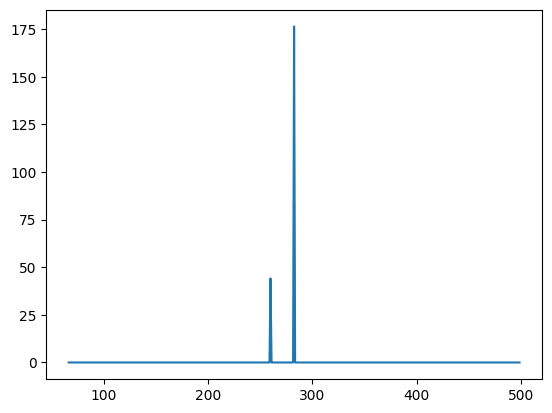

In [13]:
fdrive = Fdrive(0).cpu().numpy()
fdrive_fft = np.fft.fftshift(np.fft.fft(fdrive))
freq = fpmp[0].cpu().numpy() + np.arange(-220, 220 + 1, 1) * FSR.cpu().numpy()
plt.plot(freq*1e-12,np.abs(fdrive_fft))
plt.show()

In [14]:
MainSolver(Nt, saved_data, u0)

100%|█████████████████████████████████████████████████████████████████████████| 700000/700000 [08:32<00:00, 1366.17it/s]


In [15]:
import matplotlib.pyplot as plt
from scipy.io import loadmat
import numpy as np
data = loadmat('SSFM_half_data.mat')
u_probe = data['u_probe']

# plt.figure(figsize=(10,3))
# plt.imshow(np.abs(u_probe).T, aspect='auto',cmap='jet')
# plt.colorbar()
# plt.show()

driving_force = data['driving_force']
detuning = data['detuning'].T
kext = data['kappa_ext']
alpha = data['alpha']
k0 = data['kappa_0']
t_sim = data['t_sim'].T

Awg = np.zeros_like(u_probe, dtype=np.complex128)
Ewg = np.zeros_like(u_probe, dtype=np.complex128)
Acav = np.zeros_like(u_probe, dtype=np.complex128)
Ecav = np.zeros_like(u_probe, dtype=np.complex128)

wg = driving_force * np.sqrt(1-kext)
cav = np.sqrt(kext)*u_probe*np.exp(1j*np.pi)

Awg = (wg+cav)/np.sqrt(u_probe.shape[1])
Acav = np.sqrt(alpha/2)*u_probe*np.exp(1j*np.pi)/np.sqrt(u_probe.shape[1])

Ewg = np.fft.fftshift(np.fft.fft(Awg, axis=1),axes=1)/np.sqrt(u_probe.shape[1]) + 1e-12
Ecav = np.fft.fftshift(np.fft.fft(Acav, axis=1),axes=1)/np.sqrt(u_probe.shape[1])

Pcomb = np.sum(np.abs(Ecav)**2, axis=1) - np.abs(Ecav[:,220])**2
Pwg = np.sum(np.abs(Ewg)**2, axis=1)
Pcav = np.sum(np.abs(Ecav)**2, axis=1)
detuning_gHz = detuning*1e-9/(2*np.pi)
tr = 1e12/(2*np.pi*disp['FSR'][0])
modes = np.arange(-(len(Ecav[0])-1)//2, len(Ecav[0])//2 +1, 1)

In [16]:
# %matplotlib inline


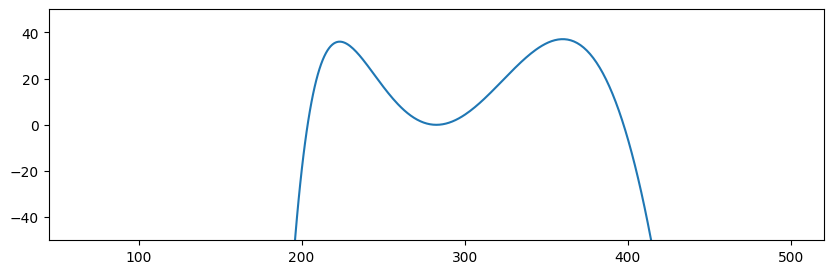

In [17]:
# %matplotlib inline
plt.figure(figsize=(10,3))
dint = Dint.cpu().numpy()*1e-9/(2*np.pi)
plt.plot(freq*1e-12,dint)
plt.ylim(-50,50)
plt.show()

In [ ]:
def plot_comb_power(ax, idx, xaxis='freq'):
    """
    Plot the frequency comb power on the provided axis.
    """
    if xaxis == 'modes':
        x = np.arange(-(len(Ecav[idx])-1)//2, len(Ecav[idx])//2 + 1, 1)
        ax.set_xlabel('Comb Line Number')
    elif xaxis == 'freq':
        x = fpmp[0].cpu().numpy() + np.arange(-(len(Ecav[idx])-1)//2, len(Ecav[idx])//2 + 1, 1) * FSR.cpu().numpy()
        x = x * 1e-12
        ax.set_xlabel('Frequency (THz)')
    x_ = np.zeros(x.size * 3)
    x_[::3] = x
    x_[1::3] = x
    x_[2::3] = x
    x = x_

    y = 10 * np.log10(np.abs(Ecav[idx])**2) + 30
    y_ = np.zeros(y.size * 3)
    floor = -100
    y_[::3] = floor
    y_[1::3] = y
    y_[2::3] = floor
    y = y_

    # ax.scatter(x, y, color='k')
    ax.vlines(x[::3], ymin=-100, ymax=y[1::3],  linestyles='-')
    # set ylim
    ax.set_ylim(-150, 30)
    ax.set_xlim(80, 470)
    ax.set_ylabel('Power (dBm)')
    ax.grid()

def plot_soliton_time(ax, idx):
    """
    Plot the soliton time-domain power on the provided axis.
    """
    tr = tR.cpu().numpy()
    t = np.linspace(-tr/2, tr/2, len(Ecav[idx])) * 1e12
    ax.plot(t, 1000*np.abs(Acav[idx])**2)
    ax.set_xlabel(r'$t_R$ (ps)',fontsize=12)
    ax.set_ylabel('Power (mW)')
    ax.grid()

def plot_intracavity_power(ax, idx):
    """
    Plot the intracavity power.
    """
    ax.plot(Pcomb*1e3)
    ax.axvline(x=idx, color='r', linestyle='--')
    ax.set_xlabel('Detuning (GHz)')
    ax.set_ylabel('Power (mW)')
    ax.grid()

def interactive_plot(idx):
    """
    Create an interactive plot with 3 rows for imshow, frequency comb, and soliton time plots.
    """
    fig, axs = plt.subplots(4, 1, figsize=(14, 12), gridspec_kw={'height_ratios': [1, 1, 1, 1]})

    # Imshow plot
    im = axs[0].imshow(np.abs(Acav).T, aspect='auto', cmap='jet', origin='lower')
    axs[0].axvline(x=idx, color='r', linestyle='--')  # Highlight the current idx
    axs[0].set_xlabel('LLE Subsampled step')
    axs[0].set_ylabel(r"$t_R$ (ps)")
    axs[0].set_title("Intensity Distribution")
    # plt.colorbar(im, ax=axs[0],  pad=0.2, label='Intensity')
    plot_intracavity_power(axs[1], idx)
    # Frequency comb plot
    plot_comb_power(axs[2], idx, xaxis='freq')

    # Soliton time-domain plot
    plot_soliton_time(axs[3], idx)

    plt.tight_layout()
    plt.show()
    # plt.close()

# get image width
image_width = '1450px'
# Create a slider widget
slider = widgets.IntSlider(
    value=1000,  # Default value
    min=0,    # Minimum value (start of idx range)
    max=len(Ecav) - 1,  # Maximum value (end of idx range)
    step=1,   # Step size
    description='Step',
    continuous_update=False,  # Update only when sliding stops,
    layout=widgets.Layout(width=image_width) 

)

# Use ipywidgets to make the plots interactive
x = interact(interactive_plot, idx=slider)


interactive(children=(IntSlider(value=1000, continuous_update=False, description='Step', layout=Layout(width='…

In [25]:
# %matplotlib inline

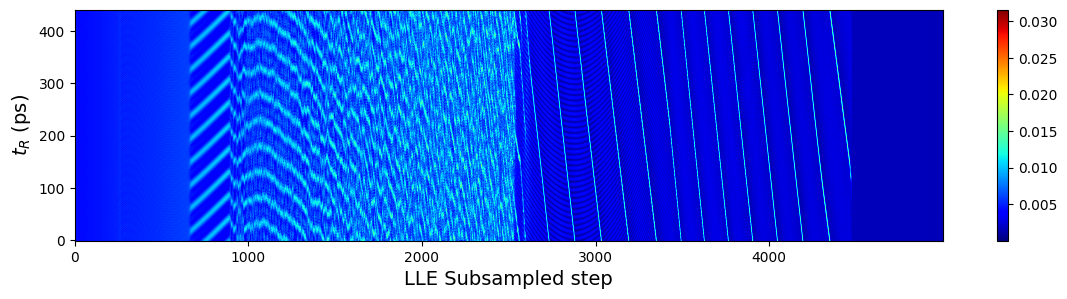

In [21]:
plt.figure(figsize=(14,3))
plt.imshow(np.abs(Acav).T, aspect='auto', cmap='jet', origin='lower')
plt.xlabel('LLE Subsampled step', fontsize=14)
plt.ylabel(r"$t_R$ (ps)", fontsize=14)
plt.colorbar()
plt.show()
# %%

In [ ]:
plt.figure(figsize=(10,3))
plt.imshow(np.abs(Ecav).T, aspect='auto', cmap='jet')#, extent=[detuning_gHz[0], detuning_gHz[-1],modes[0], modes[-1]]
plt.colorbar()
plt.xlabel('Detuning (GHz)', fontsize=14)
plt.ylabel(r"$\mu$", fontsize=14)
plt.show()
# %%

In [ ]:
plt.figure(figsize=(10,3))
plt.plot(detuning*1e-9/(2*np.pi), np.flip(Pcomb)*1e3)
plt.xlabel('Detuning (GHz)')
plt.ylabel('Power (mW)')
plt.grid()
plt.show()
# %%

In [ ]:
def plot_comb_power(idx, xaxis='freq'):
    if xaxis == 'modes':
        x = np.arange(-(len(Ecav[idx])-1)//2, len(Ecav[idx])//2 +1, 1)
        plt.xlabel('Comb Line Number')
    elif xaxis == 'freq':
        x = fpmp[0].cpu().numpy() + np.arange(-(len(Ecav[idx])-1)//2, len(Ecav[idx])//2 +1, 1)*FSR.cpu().numpy()
        x = x*1e-12
    x_ = np.zeros(x.size*3)
    x_[::3] = x
    x_[1::3] = x
    x_[2::3] = x
    x = x_

    y = 10*np.log10(np.abs(Ecav[idx])**2)+30
    y_ = np.zeros(y.size * 3)
    floor = -100
    y_[::3] = floor
    y_[1::3] = y
    y_[2::3] = floor
    y = y_

    plt.figure(figsize=(18,4))
    plt.scatter(x, y, color='k')
    # for xx,yy in zip(x, y):
    plt.vlines(x[::3], ymin=-100, ymax=y[1::3], colors='k', linestyles='-', alpha=0.7)
    
    plt.ylabel('Power (dBm)')
    plt.grid()
    plt.show()

# %%
plot_comb_power(4000)

In [ ]:
def plot_soliton_time(idx):
    tr = tR.cpu().numpy()
    t = np.linspace(-tr/2,tr/2, len(Ecav[idx]))*1e12

    plt.figure(figsize=(14,4))
    plt.plot(t, np.abs(Acav[idx])**2)
    plt.xlabel('Time (ps)')
    plt.ylabel('Power (W)')
    plt.grid()
    plt.show()
# %%
plot_soliton_time(4000)